# Initialize

In [9]:
#  Python Modules
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
# import requests
import json
import math
import itertools
from cycler import cycler
from matplotlib.ticker import FormatStrFormatter

# Custom Modules
import CensusData
import CovidData

# Covid Data    
https://covidtracking.com/api  
https://github.com/nytimes/covid-19-data

## Download and Import Data

In [10]:


# Data sources
urlNYT_States = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
urlNYT_Counties = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
urlCovid_States = 'https://covidtracking.com/api/v1/states/daily.csv'

# Download data
dfNYT_StatesRaw = pd.read_csv(urlNYT_States)
dfNYT_CountiesRaw = pd.read_csv(urlNYT_Counties)
dfCovid_StatesRaw = pd.read_csv(urlCovid_States)

print('NYT States: ', dfNYT_StatesRaw.shape,
      '\nNYT Counties: ', dfNYT_CountiesRaw.shape,
      '\nCovid States: ', dfCovid_StatesRaw.shape)



https://api.census.gov/data/2019/pep/population?get=POP&for=state:*
Population data API call result: 200 OK
https://api.census.gov/data/2010/dec/sf1?get=NAME&for=state:*
State name API call result: 200 OK
NYT States:  (2833, 5) 
NYT Counties:  (81339, 6) 
Covid States:  (2713, 25)


In [ ]:
# Census Data
dfStateData = CensusData.StateData()

# Covid Data
dfCovid = CovidData.combine_data()

# State Level Events
dfEvents = pd.read_csv('Events.txt',parse_dates=[1])

# Prep Data

In [5]:
dfNYT_States = dfNYT_StatesRaw
dfNYT_Counties = dfNYT_CountiesRaw
dfCovid_States = dfCovid_StatesRaw

dfNYT_States['date'] = pd.to_datetime(dfNYT_States['date'],format='%Y-%m-%d')
dfNYT_Counties['date'] = pd.to_datetime(dfNYT_Counties['date'],format='%Y-%m-%d')
dfCovid_States['date'] = pd.to_datetime(dfCovid_States['date'],format='%Y%m%d')

print('Fixed dates to datetimes')



Fixed dates to datetimes


In [13]:
print(dfNYT_StatesRaw.columns.values)
print(dfCovid_StatesRaw.columns.values)
print(dfNYT_States.columns.values)
print(dfCovid_States.columns.values)

['date' 'state' 'fips' 'cases' 'deaths']
['date' 'state' 'positive' 'negative' 'pending' 'hospitalizedCurrently'
 'hospitalizedCumulative' 'inIcuCurrently' 'inIcuCumulative'
 'onVentilatorCurrently' 'onVentilatorCumulative' 'recovered' 'hash'
 'dateChecked' 'death' 'hospitalized' 'total' 'totalTestResults' 'posNeg'
 'fips' 'deathIncrease' 'hospitalizedIncrease' 'negativeIncrease'
 'positiveIncrease' 'totalTestResultsIncrease']
['date' 'state' 'fips' 'cases' 'deaths']
['date' 'state' 'positive' 'negative' 'pending' 'hospitalizedCurrently'
 'hospitalizedCumulative' 'inIcuCurrently' 'inIcuCumulative'
 'onVentilatorCurrently' 'onVentilatorCumulative' 'recovered' 'hash'
 'dateChecked' 'death' 'hospitalized' 'total' 'totalTestResults' 'posNeg'
 'fips' 'deathIncrease' 'hospitalizedIncrease' 'negativeIncrease'
 'positiveIncrease' 'totalTestResultsIncrease']


# Data Analysis

## Deaths correlated to cases from previous days

In [6]:
shiftSearch = 30

groupedStates = dfNYT_States.groupby('state')

stateDict = groupedStates.groups.keys()
shiftHeadings = ['Shift_'+str(i) for i in range(shiftSearch)]


dfShiftCor = pd.DataFrame(columns = shiftHeadings,index = stateDict)


for title, group in groupedStates:   
    stateCases = group[['date','cases']]
    stateCases = stateCases.set_index('date')
    stateCases['cases_log'] = np.log(stateCases['cases'])

    for i in range(shiftSearch):
        stateDeathsShift = group[['date','deaths']]
        stateDeathsShift['date'] = stateDeathsShift['date'] + pd.Timedelta(days=-i)
        stateDeathsShift = stateDeathsShift.set_index('date')
        stateCases['deathsShift_'+str(i)] = stateDeathsShift
        stateCases['deathsShiftlog_'+str(i)] = np.log(stateCases['deathsShift_'+str(i)])
    
    for i in range(shiftSearch):
        caseAutocorr = stateCases['cases'].autocorr(lag=i)
        dfShiftCor.at[title,'Case_autocorr_'+str(i)] = caseAutocorr
    
    for i in range(shiftSearch):
        caseAutocorrLog = stateCases['cases_log'].autocorr(lag=i)
        dfShiftCor.at[title,'Case_autocorr_log'+str(i)] = caseAutocorrLog
        
    for (columnName, columnData) in stateCases.iteritems():
        if 'deathsShift_' in columnName:
            corDeath = stateCases[['cases',columnName]].corr().iloc[0::2,-1].mean()
            dfShiftCor.at[title,'Shift_'+columnName[12:]] = corDeath
            #print('State: ', title,' Shift: ', columnName[12:], ' Correlation: ', round(corDeath,3))
        if 'deathsShiftlog_' in columnName:
            corDeath = stateCases[['cases_log',columnName]].corr().iloc[0::2,-1].mean()
            dfShiftCor.at[title,'Shift_log_'+columnName[15:]] = corDeath


C:\Users\Scott\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Scott\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Scott\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\Scott\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


## State level analysis

In [7]:
firstDate = min(dfNYT_States['date'].min(),dfCovid_States['date'].min())
currentDate = max(dfNYT_States['date'].max(),dfCovid_States['date'].max())

dfEventsAll = dfEvents.groupby('FIPS').get_group('All')

for stateFIPS, stateData in dfStateData.iterrows():
    groupNYTState = dfNYT_States.groupby('fips').get_group(int(stateFIPS))
    groupCovidState = dfCovid_States.groupby('fips').get_group(int(stateFIPS))
    groupCovidState = groupCovidState.sort_values(by=['date']) # Change to ascending dates for moving average
    if str(stateFIPS).zfill(2) in dfEvents.groupby('FIPS').groups.keys():
        dfEventsState = dfEventsAll.append(dfEvents.groupby('FIPS').get_group(str(stateFIPS).zfill(2)))
    else:
        dfEventsState = dfEventsAll

    plotCols = 3
    plotRows = 3
    fig = plt.figure(figsize=(plotCols * 10, plotRows * 5))
    axTrackingRaw = fig.add_subplot(plotRows, plotCols, 1)
    axTrackingLog = fig.add_subplot(plotRows, plotCols, 2)
    axResourceRaw = fig.add_subplot(plotRows, plotCols, 8)
    axResourceLog = fig.add_subplot(plotRows, plotCols, 9)
    axTestingDays = fig.add_subplot(plotRows, plotCols, 5)
    axTestingGrow = fig.add_subplot(plotRows, plotCols, 6)
    axTestPercent = fig.add_subplot(plotRows, plotCols, 7)
    axCorrelation = fig.add_subplot(plotRows, plotCols, 4)
    axRnaughtCalc = fig.add_subplot(plotRows, plotCols, 3)
    
    def raw2capita(x):
        return x * 10000 / int(dfStateData.at[str(stateFIPS).zfill(2), 'Population'])
    def capita2raw(x):
        return x * int(dfStateData.at[str(stateFIPS).zfill(2), 'Population']) / 10000
    
    # Tracking Plots
    for ax in [axTrackingRaw, axTrackingLog]:
        ax.plot(groupNYTState['date'],groupNYTState['cases'], label = 'Cases (NYT)')
        ax.plot(groupNYTState['date'],groupNYTState['deaths'], label = 'Deaths (NYT)')
        ax.plot(groupCovidState['date'],groupCovidState['positive'], label = 'Cases (CovidTracking)')
        ax.plot(groupCovidState['date'],groupCovidState['death'], label = 'Deaths (CovidTracking)')
        ax.plot(groupCovidState['date'],groupCovidState['hospitalizedCumulative'], label = 'Hospitalized (CovidTracking)')
        ax.plot(groupCovidState['date'],groupCovidState['inIcuCumulative'], label = 'ICU (CovidTracking)')
        ax.plot(groupCovidState['date'],groupCovidState['onVentilatorCumulative'], label = 'On Ventilator (CovidTracking)')

        axCapita = ax.secondary_yaxis('right', functions=(raw2capita, capita2raw), )
        axCapita.set_ylabel('Per 10,000')
        
        # Add Event markers
        ymin, ymax = plt.ylim()
        arrowprops = {'width': 1, 'headwidth': 1, 'headlength': 1, 'shrink':0.05}
        bbox = dict(facecolor = '1', edgecolor = 'none', alpha = 0.8, pad = 0)
        for index, eventData in dfEventsState.iterrows():
            ax.axvline(eventData['Date'], color = 'gray', linestyle = ':')
            ax.annotate(eventData['Event'], xy=(eventData['Date'],ymax), xytext=(-5,0), textcoords='offset points',
                        rotation=90, va='bottom', ha='center', annotation_clip=False, arrowprops=arrowprops, bbox=bbox)
        
        ax.set(
            title = 'Cumulative Tracking Data',
            xlim = [firstDate, currentDate])
        ax.legend()

    axTrackingLog.set(
        yscale = 'log')

    # Current Resource Usage
    for ax in [axResourceRaw, axResourceLog]:
        ax.plot(groupCovidState['date'],groupCovidState['hospitalizedCurrently'], label = 'Hospitalized (CovidTracking)')
        ax.plot(groupCovidState['date'],groupCovidState['inIcuCurrently'], label = 'ICU (CovidTracking)')
        ax.plot(groupCovidState['date'],groupCovidState['onVentilatorCurrently'], label = 'On Ventilator (CovidTracking)')

        axCapita = ax.secondary_yaxis('right', functions=(raw2capita, capita2raw))
        axCapita.set_ylabel('Per 10,000')
        
        ax.set(
            title = 'Current Resource Usuage',
            xlim = [firstDate, currentDate])
        ax.legend()

    axResourceLog.set(
        yscale = 'log')

    # Daily Testing
    axTestingDays.scatter(groupCovidState['date'],groupCovidState['totalTestResultsIncrease'], label = 'Daily Testing (CovidTracking)', marker = '.')
    dailyMoving3 = groupCovidState.totalTestResultsIncrease.rolling(window=3).mean()
    dailyMoving7 = groupCovidState.totalTestResultsIncrease.rolling(window=7).mean()
    axTestingDays.plot(groupCovidState['date'], dailyMoving3, label = 'Daily Testing (3 day)')
    axTestingDays.plot(groupCovidState['date'], dailyMoving7, label = 'Daily Testing (7 day)')

    axCapita = axTestingDays.secondary_yaxis('right', functions=(raw2capita, capita2raw))
    axCapita.set_ylabel('Per 10,000')
    
    axTestingDays_ymin = min(dailyMoving3.min(), dailyMoving7.min(), 0) * 1.1
    axTestingDays_ymax = max(dailyMoving3.max(), dailyMoving7.max()) * 1.1
    axTestingDays.set(
        title = 'Daily Testing',
        xlim = [firstDate, currentDate],
        ylim = [axTestingDays_ymin, axTestingDays_ymax])
    axTestingDays.legend()

    # Testing Growth
    axTestingGrow.axhline(y=0, color='dimgray', linewidth = 1)
    
    testingGrowth = groupCovidState['totalTestResultsIncrease'].diff()
    axTestingGrow.scatter(groupCovidState['date'],testingGrowth, label = 'Daily Testing Growth (CovidTracking)', marker = '.')
    growthMoving3 = testingGrowth.rolling(window=3).mean()
    growthMoving7 = testingGrowth.rolling(window=7).mean()
    axTestingGrow.plot(groupCovidState['date'],growthMoving3, label = 'Testing Growth (3 day)')
    axTestingGrow.plot(groupCovidState['date'],growthMoving7, label = 'Testing Growth (7 day)')

    axCapita = axTestingGrow.secondary_yaxis('right', functions=(raw2capita, capita2raw))
    axCapita.set_ylabel('Per 10,000')
    
    axTestingGrow_ymin = min(growthMoving3.min(), growthMoving7.min(), 0) * 1.1
    axTestingGrow_ymax = max(growthMoving3.max(), growthMoving7.max()) * 1.1
    axTestingGrow.set(
        title = 'Testing Growth',
        xlim = [firstDate, currentDate],
        ylim = [axTestingGrow_ymin, axTestingGrow_ymax])
    axTestingGrow.legend()

    # Percent Positive
    percentPositive = groupCovidState['positive'] / groupCovidState['totalTestResults']
    percentPositive3day = percentPositive.rolling(window=3).mean()
    percentPositive7day = percentPositive.rolling(window=7).mean()

    percentPositiveNew = groupCovidState['positiveIncrease'] / groupCovidState['totalTestResultsIncrease']
    percentPositiveNew3day = percentPositiveNew.rolling(window=3).mean()
    percentPositiveNew7day = percentPositiveNew.rolling(window=7).mean()

    axTestPercent.scatter(groupCovidState['date'],percentPositive, label = '% Positive Results Total (Covid)', color = 'tab:blue', marker = '.')
    axTestPercent.plot(groupCovidState['date'],percentPositive3day, label = '% Positive Results Total (3 day)', color = 'tab:blue', linestyle = '--')
    axTestPercent.plot(groupCovidState['date'],percentPositive7day, label = '% Positive Results Total (7 day)', color = 'tab:blue', linestyle = ':')

    axTestPercent.scatter(groupCovidState['date'],percentPositiveNew, label = '% New Positive Results Total (Covid)', color = 'tab:orange', marker = '.')
    axTestPercent.plot(groupCovidState['date'],percentPositiveNew3day, label = '% New Positive Results Total (3 day)', color = 'tab:orange', linestyle = '--')
    axTestPercent.plot(groupCovidState['date'],percentPositiveNew7day, label = '% New Positive Results Total (7 day)', color = 'tab:orange', linestyle = ':')
    
    axTestPercent.set(
        title = 'Positive Test Results',
        xlim = [firstDate, currentDate])
    axTestPercent.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    axTestPercent.legend()

    # Case/Death correlations
    caseDeathCor = dfShiftCor.loc[stateData['State'],dfShiftCor.columns.str.match('Shift_\d')]
    caseDeathCorLog = dfShiftCor.loc[stateData['State'],dfShiftCor.columns.str.match('Shift_log_')]
    caseAutoCor = dfShiftCor.loc[stateData['State'],dfShiftCor.columns.str.match('Case_autocorr_\d')]
    caseAutoCorLog = dfShiftCor.loc[stateData['State'],dfShiftCor.columns.str.match('Case_autocorr_log')]
    
    axCorrelation.plot(range(shiftSearch),caseDeathCor, label = 'Case vs. Deaths Shifted, Raw (NYT)')
    axCorrelation.plot(range(shiftSearch),caseDeathCorLog, label = 'Case vs. Deaths Shifted, Log-Log (NYT)')
    axCorrelation.plot(range(shiftSearch),caseAutoCor, label = 'Case Autocorrelation, Raw (NYT)')
    axCorrelation.plot(range(shiftSearch),caseAutoCorLog, label = 'Case Autocorrelation, Log (NYT)')
    
    axCorrelation.set(
        title = 'Cases related to X days later',
        xticks = range(0,shiftSearch,2), 
        xticklabels = range(0,shiftSearch,2),
        xlabel = 'Days later', 
        xlim = [0, shiftSearch - 1],
        ylim = [0.7, 1])
    axCorrelation.legend()
  
    # Ro Estimations
    tObserved = [1, 3, 7]
    for T in tObserved:
        try:
            Reff = groupCovidState['positive'] / groupCovidState['positive'].shift(T)
        except ZeroDivisionError:
            Reff = float('nan')
        
        try:
            newTestsScaling = groupCovidState['totalTestResults'] / groupCovidState['totalTestResults'].shift(T)
            ReffScale = groupCovidState['positive'] / (groupCovidState['positive'].shift(T) * newTestsScaling)
        except ZeroDivisionError:
            ReffScale = float('nan')            
        
        axRnaughtCalc.plot(groupCovidState['date'], Reff, label = 'Observed R (t=' + str(T) + ')', linestyle = ':')
        axRnaughtCalc.plot(groupCovidState['date'], ReffScale, label = 'Observed R scaled (t=' + str(T) + ')', linestyle = '--')
        
    axRnaughtCalc.set(
        title = 'R estimates from Positive results',
        xlim = [firstDate, currentDate],
        ylim = [0.6, 6],
        yscale = 'log')
    axRnaughtCalc.legend()
    axRnaughtCalc.grid(axis = 'y', which = 'both')
    axRnaughtCalc.yaxis.tick_right()
    axRnaughtCalc.yaxis.set_minor_formatter(FormatStrFormatter('%.1f'))
    axRnaughtCalc.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    # Add Event markers
    ymin, ymax = axRnaughtCalc.get_ylim()
    arrowprops = {'width': 1, 'headwidth': 1, 'headlength': 1, 'shrink':0.05}
    bbox = dict(facecolor = '1', edgecolor = 'none', alpha = 0.8, pad = 0)
    for index, eventData in dfEventsState.iterrows():
        axRnaughtCalc.axvline(eventData['Date'], color = 'gray', linestyle = ':')
        axRnaughtCalc.annotate(eventData['Event'], xy=(eventData['Date'],ymin), xytext=(-5,5), textcoords='offset points',
                    rotation=90, va='bottom', ha='center', annotation_clip=False, arrowprops=arrowprops, bbox=bbox)

    # Overall figure formatting   
    fig.suptitle(stateData['State'],
                fontsize = 18,
                fontweight = 'bold')
    fig.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.savefig('figs/Tracking Data ' + stateData['State'])
    plt.close(fig)
    

C:\Users\Scott\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


### Test Code for State by State plots

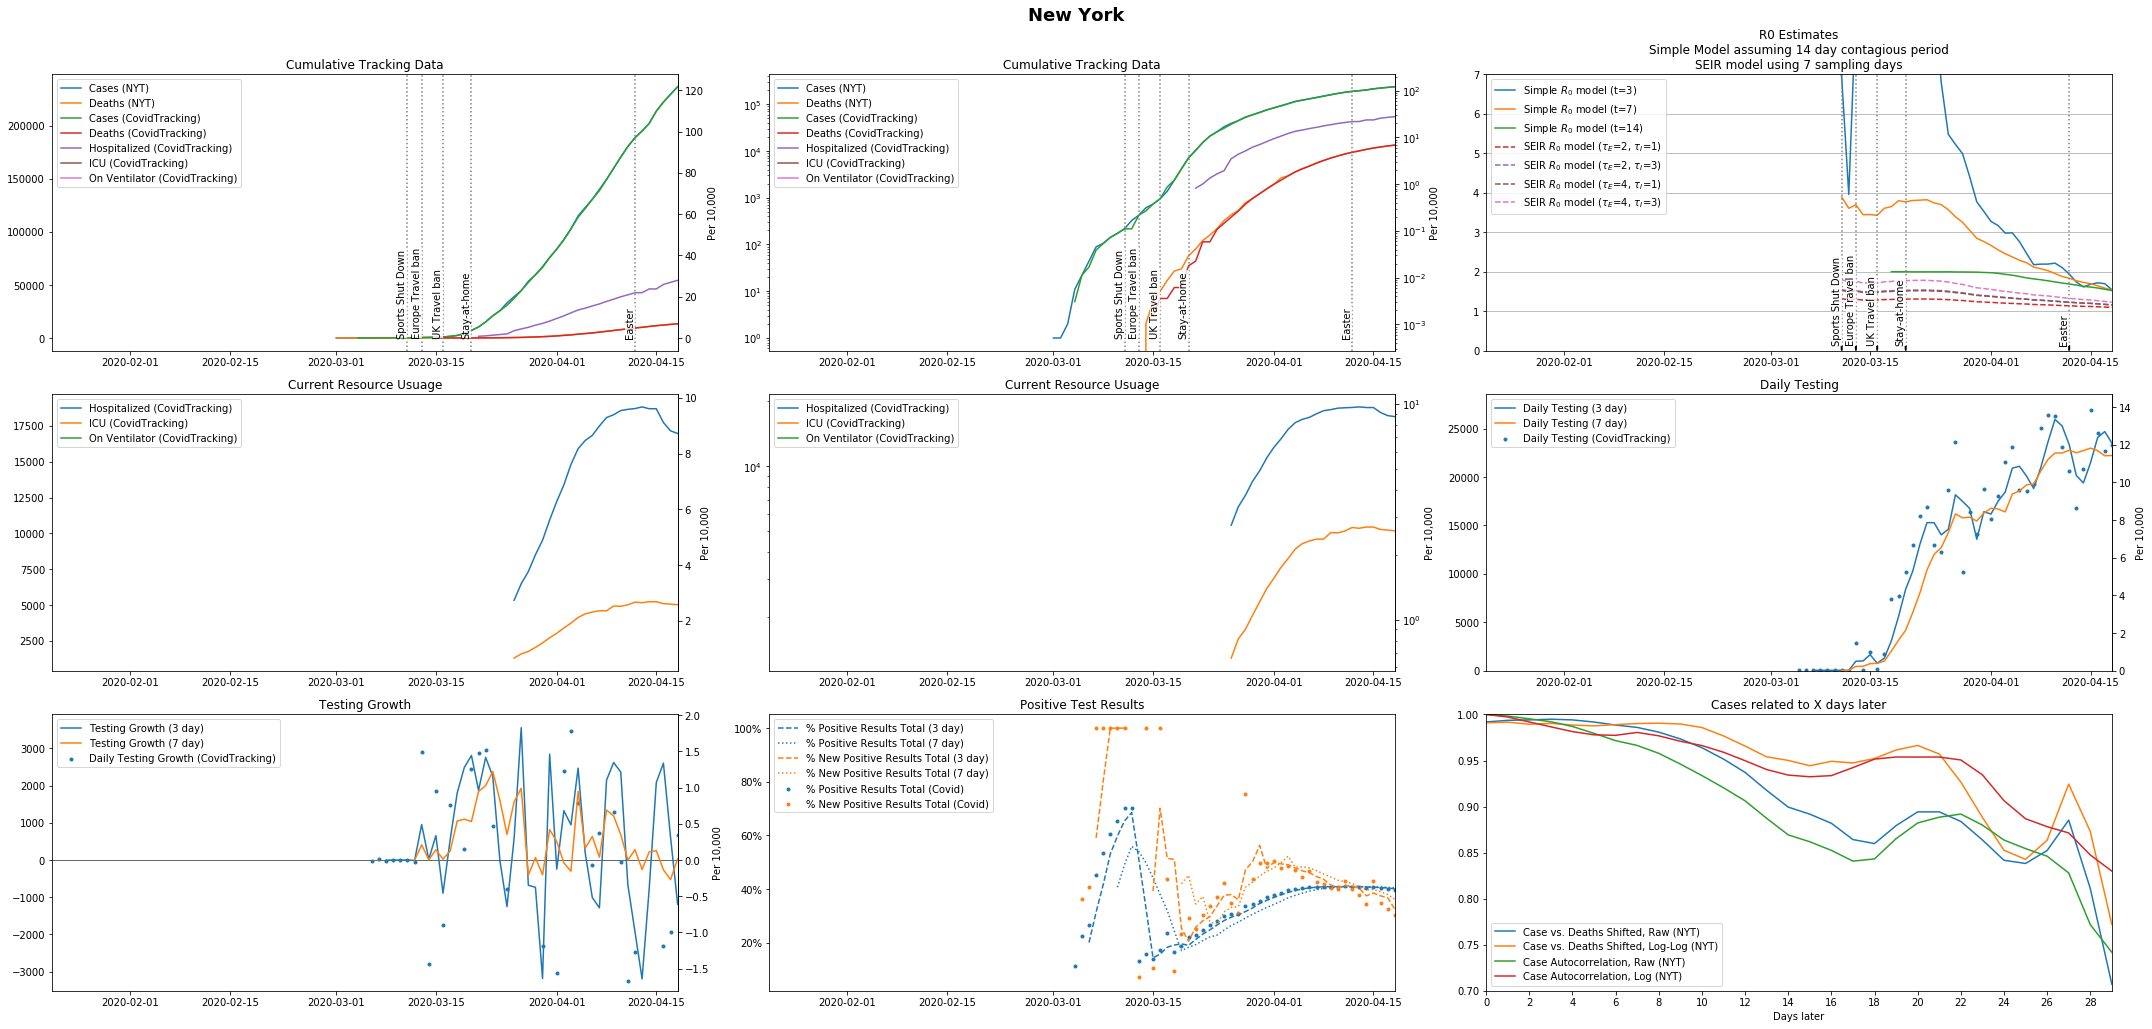

In [145]:
    #   Required Stuff for testing
    stateFIPS = 36
    firstDate = min(dfNYT_States['date'].min(),dfCovid_States['date'].min())
    currentDate = max(dfNYT_States['date'].max(),dfCovid_States['date'].max())
    
    dfEvents = pd.read_csv('Events.txt',parse_dates=[1])
    dfEventsAll = dfEvents.groupby('FIPS').get_group('All')
    
#   Start here for copy/paste into loop


# Overall figure formatting
    fig.suptitle(dfStateData.at[str(stateFIPS).zfill(2),'State'], 
                fontsize = 18,
                fontweight = 'bold')
    fig.tight_layout(rect=[0, 0.03, 1, 0.97])

In [8]:
# dfCovid_States.columns.values
# print(dfStateData.index[dfStateData['State'] == 'California'])
# print(dfStateData.at['06','State'])
print(groupCovidState.columns.values)

['date' 'state' 'positive' 'negative' 'pending' 'hospitalizedCurrently'
 'hospitalizedCumulative' 'inIcuCurrently' 'inIcuCumulative'
 'onVentilatorCurrently' 'onVentilatorCumulative' 'recovered' 'hash'
 'dateChecked' 'death' 'hospitalized' 'total' 'totalTestResults' 'posNeg'
 'fips' 'deathIncrease' 'hospitalizedIncrease' 'negativeIncrease'
 'positiveIncrease' 'totalTestResultsIncrease']


### Plots for Death vs. Cases 'x' days before
For US, averaged from each state (weighted equally)

In [20]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,9))
dfShiftCor.mean().head(shiftSearch).plot(ax=ax1)
dfShiftCor.mean().tail(shiftSearch).plot(ax=ax1)
dfShiftCor.mean()[shiftSearch:shiftSearch*2].plot(ax=ax2)
dfShiftCor.mean()[shiftSearch*2:shiftSearch*3].plot(ax=ax2)

ax1.set_title('Deaths Correlated to Cases from # of days before')
ax1.set_xticks(range(0,shiftSearch,2))
ax1.set_xticklabels([])
ax1.legend(['Raw', 'Log-Log'])

ax2.set_title('Case Auto-correlation')
ax2.set_xticks(range(0,shiftSearch,2))
ax2.set_xticklabels(range(0,shiftSearch,2))
ax2.legend(['Raw', 'Log'])

plt.savefig('figs/Deaths delayed from cases')
plt.close(fig)

### Plots for Death vs. Cases 'x' days before for each state

In [19]:
fig, axes = plt.subplots(len(dfShiftCor),1,figsize=(10,150))

for ax, state in zip(axes, dfShiftCor.iterrows()):
    state[1].T.tail(shiftSearch).plot(ax=ax)
    ax.set(
        title=state[0],
        xticks=range(0,shiftSearch,2), 
#         xticklabels = [],
        xticklabels = range(0,shiftSearch,2),
        xlabel='', 
        ylim=[0.7,1])


fig.suptitle('Deaths Correlated to Cases from # of days before (Log-Log)')
fig.tight_layout(rect=[0, 0.03, 1, 0.978])

plt.savefig('figs/State Case-Death Correlations')
plt.close(fig)

## R0 Estimations

### Simple R0 Estimate  
https://en.wikipedia.org/wiki/Basic_reproduction_number#Simple_model

In [151]:
def DoublingTime(r, t):
    try:
        td = t * math.log(2)/math.log(1 + r)
    except ZeroDivisionError:
        td = float('nan')
    return td

def Rnaught(K, tau):
    return math.exp(K * tau)

def SimpleR0model(positiveResults, t, tau):
    r = 1 - (positiveResults.shift(t) / positiveResults)
    doubleTime = r.apply(DoublingTime,args=[t])
    K = math.log(2) / doubleTime
    R0 = K.apply(Rnaught, args = [tau])
    return R0

### SEIR R0 Estimation  
https://en.wikipedia.org/wiki/Basic_reproduction_number#Latent_infectious_period,_isolation_after_diagnosis  

In [152]:
def SEIRR0model(positiveResults, t, tauE, tauI):
    r = 1 - (positiveResults.shift(t) / positiveResults)
    doubleTime = r.apply(DoublingTime,args=[t])
    K = math.log(2) / doubleTime
    R0 = 1 + (K * (tauE + tauI)) + (np.power(K, 2) * tauE * tauI)
    return R0